# 모델링 작업

## 전처리 데이터 출처
- 적조 발생여부 
- 국립수산과학원(발생일, 발생해안, 적조생물, 개체수, 발생당시 수온)
[https://www.nifs.go.kr/rtm/TRS/gispop/redtide.jsp](https://www.nifs.go.kr/rtm/TRS/gispop/redtide.jsp) ('12~'22)
[https://www.nifs.go.kr/red/news_2.red](https://www.nifs.go.kr/red/news_2.red) (’81~’20)
- 생물밀도 
-  국립수산과학원(발생일, 발생해안, 적조생물, 개체수, 발생당시 수온)
[https://www.nifs.go.kr/rtm/TRS/gispop/redtide.jsp](https://www.nifs.go.kr/rtm/TRS/gispop/redtide.jsp) ('12~'22)
[https://www.nifs.go.kr/red/news_2.red](https://www.nifs.go.kr/red/news_2.red) (’81~’20)
- 수온 및 기온
- 국립수산과학원 < [관측정보검색<연안정지관측자료<해양관측자료<KODC (nifs.go.kr)](https://www.nifs.go.kr/kodc/coo_list_select.kodc)
- 기상청 < 기상자료개방포털 ([https://data.kma.go.kr/data/sea/selectBuoyRltmList.do?pgmNo=52](https://data.kma.go.kr/data/sea/selectBuoyRltmList.do?pgmNo=52))
- 강수량 
    - [기상자료개방포털[기후통계분석:기상현상일수:강수일수:기간조회] (kma.go.kr)](https://data.kma.go.kr/stcs/grnd/grndRnDay.do?pgmNo=156) (월별)
- 일조량 
- e 나라 지표 ([http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1402](http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1402))
- 운량(풍속)
- - 국립수산과학원 - 한국해양자료센터 (운량 6개월 분량) ([https://www.nifs.go.kr/kodc/coo_list_select.kodc](https://www.nifs.go.kr/kodc/coo_list_select.kodc))

### 데이터 샘플
- 하루마다 데이터를 구해서 총 1달 기간의 수온, 기온, 강수량, 일조량, 풍속(독립변수 5개), 적조발생여부(종속변수)
- 가상환경 : python 3.9.13
- 사용할 머신러닝 : LSTM, GRU 
- 이진분류 : 적조 발생 유무 (회귀로 적조 발생량 예측을 할수도)

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, GRU, Dense, Dropout, Flatten, Embedding
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Recall, Precision
from keras.utils import set_random_seed, to_categorical, plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
set_random_seed(42)

In [9]:
# 데이터 프레임 불러오기
input_data = pd.read_csv("./data/input_data.csv", index_col=0)
target_data = pd.read_csv("./data/target_data.csv", index_col=0)

In [15]:
input_data1 = input_data.iloc[:,0:8]
input_data2 = input_data.iloc[:,8:]

In [458]:
input_data.iloc[:,0:8].to_csv("example_input")
target_data.iloc[:,0:2].to_csv("example_target")

In [17]:
target_data1 = target_data.iloc[:,0:2]
target_data2 = target_data.iloc[:,2:]

In [21]:
input_data2

,지점.2,평균 풍속(m/s).1,평균 상대습도(%).1,평균 기온(°C).1,평균 수온(°C).1,일강수량(mm).1,합계 일조시간(hr).1
0,통영,5.97022,62.000000,9.400000,17.300000,0.0,8.6
1,통영,5.97022,65.000000,12.000000,16.800000,0.0,6.9
2,통영,4.80000,58.000000,9.600000,15.300000,0.0,8.7
3,통영,4.20000,49.000000,10.500000,13.900000,0.0,7.7
4,통영,8.90000,68.000000,11.100000,13.800000,0.0,2.3
...,...,...,...,...,...,...,...
2094,통영,5.97022,71.893199,16.124387,18.166765,0.0,0.7
2095,통영,5.97022,71.893199,16.124387,18.166765,0.1,5.7
2096,통영,5.97022,71.893199,16.124387,18.166765,0.0,4.5
2097,통영,5.97022,71.893199,16.124387,18.166765,0.0,9.7


In [23]:
input_data1.drop(columns=["지점", "평균 상대습도(%)", "일시"], inplace=True)
input_data2.drop(columns=["지점.2", "평균 상대습도(%).1"], inplace=True)

input_data2.rename(columns={"평균 풍속(m/s).1":"평균 풍속(m/s)", "평균 기온(°C).1":"평균 기온(°C)", "평균 수온(°C).1": "평균 수온(°C)", "일강수량(mm).1": "일강수량(mm)", "합계 일조시간(hr).1" : "합계 일조시간(hr)"}, inplace=True)

In [37]:
target_data1.drop(columns=["지점_x"], inplace=True)
target_data2.drop(columns=["지점_y"], inplace=True)
target_data1.rename(columns={"target_x": "target"}, inplace=True)
target_data2.rename(columns={"target_y": "target"}, inplace=True)

In [44]:
print(input_data1.shape, target_data1.shape)

(2099, 5) (2099, 1)


### 자료 없는 17년도 날리기

In [61]:
target_data1.iloc[0:364,:].index # 0~ 364 행까지 2017년

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       ...
       '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
       '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30'],
      dtype='object', name='일시', length=364)

In [65]:
input_data1.drop(input_data1.iloc[0:365,:].index, inplace=True)
input_data2.drop(input_data2.iloc[0:365,:].index, inplace=True)
target_data1.drop(target_data1.iloc[0:365,:].index, inplace=True)
target_data2.drop(target_data2.iloc[0:365,:].index, inplace=True)

In [70]:
input_data1.reset_index(inplace=True)
input_data1.drop(columns=["index"], inplace=True)
input_data2.reset_index(inplace=True)
input_data2.drop(columns=["index"], inplace=True)

In [74]:
target_data1.reset_index(inplace=True)
target_data1.drop(columns=["일시"], inplace=True)
target_data2.reset_index(inplace=True)
target_data2.drop(columns=["일시"], inplace=True)

### 타겟값 상한 설정 : 1000 으로

In [84]:
print(target_data1.value_counts())
print(target_data2.value_counts())

target
0.0       1719
100.0        1
360.0        1
500.0        1
560.0        1
700.0        1
930.0        1
1000.0       1
1120.0       1
1408.0       1
1440.0       1
1500.0       1
1536.0       1
1640.0       1
3616.0       1
3800.0       1
dtype: int64
target
0.0       1690
1.0          7
700.0        3
40.0         2
100.0        2
350.0        2
500.0        2
800.0        2
50.0         2
1000.0       2
1200.0       2
1500.0       1
6000.0       1
5800.0       1
5200.0       1
4800.0       1
4500.0       1
3200.0       1
3040.0       1
900.0        1
1440.0       1
20.0         1
270.0        1
180.0        1
150.0        1
90.0         1
80.0         1
56.0         1
7300.0       1
dtype: int64


In [85]:
def get_dens(v):
    if v >= 1000:
        density = 1000
    else:
        density = v
    return density

# get_dens(v) 함수 적용
target_data1["target"] = target_data1["target"].apply(lambda v : get_dens(v))
target_data2["target"] = target_data2["target"].apply(lambda v : get_dens(v))

In [86]:
target_data1.value_counts()

target
0.0       1719
1000.0       9
100.0        1
360.0        1
500.0        1
560.0        1
700.0        1
930.0        1
dtype: int64

## 오버샘플링
### df : 모든 데이터 merge된 dataframe
- 거제 데이터 19~22년도 1000개 제거 

In [105]:
target_data1.iloc[700:,:].value_counts()

target
0.0       1034
dtype: int64

In [115]:
target_data1.drop(target_data1.iloc[700:,:].index, inplace=True)

In [125]:
input_data1.drop(input_data1.iloc[700:,:].index, inplace=True)

In [127]:
print(target_data1.shape, target_data2.shape)
print(input_data1.shape, input_data2.shape)

(700, 2) (1734, 2)
(700, 5) (1734, 5)


In [99]:
target_data2.iloc[1300:,:].value_counts()

target
0.0       425
1.0         7
270.0       1
900.0       1
dtype: int64

In [109]:
# Oversampling을 위해 데이터 복제

# # Oversampling 1. 앞 쪽 데이터 증식
def oversample(df, TRAIN_SPLIT):
    df['target_oversample'] = df['target']
    for i in range(2,TRAIN_SPLIT):
        if df['target_oversample'].iloc[i-2] == 0 and df['target_oversample'].iloc[i-1] == 0 and df['target_oversample'].iloc[i] != 0:
            df['target_oversample'].iloc[i-2] = (df['target_oversample'].iloc[i])*1/3
            df['target_oversample'].iloc[i-1] = (df['target_oversample'].iloc[i])*2/3
            
        elif df['target_oversample'].iloc[i-1] == 0 and df['target_oversample'].iloc[i] != 0:
            df['target_oversample'].iloc[i-1] = (df['target_oversample'].iloc[i])*1/2
    # # Oversampling 2. 뒤 쪽 데이터 증식
    for i in range(0,TRAIN_SPLIT):
        if df['target_oversample'].iloc[i+2] == 0 and df['target_oversample'].iloc[i+1] == 0 and df['target_oversample'].iloc[i] != 0:
            df['target_oversample'].iloc[i+2] = (df['target_oversample'].iloc[i])*1/3
            df['target_oversample'].iloc[i+1] = (df['target_oversample'].iloc[i])*2/3
            i = i+2
    return df

In [119]:
oversample(target_data1, len(target_data1)-2).value_counts()

target  target_oversample
0.0     0.000000e+00         211
1000.0  1.000000e+03           9
0.0     6.200000e+02           2
        3.100000e+02           2
        1.890714e-91           1
                            ... 
        1.552579e-54           1
        1.035052e-54           1
        5.175262e-55           1
        3.450175e-55           1
        1.132544e-34           1
Length: 480, dtype: int64

In [450]:
len(target_data1)

700

In [112]:
TRAIN_SPLIT = 1300
target_data2 = oversample(target_data2, TRAIN_SPLIT)
target_data1 = oversample(target_data1, len(target_data1)-2)

,target,target_oversample
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1729,0.0,0.0
1730,0.0,0.0
1731,0.0,0.0
1732,0.0,0.0


## 표준화
#### data엔 StandardScaler로 표준화 작업, target엔 이진분류면 OneHotEncoder, 회귀는 그대로

In [453]:
np.save('input_data1.npy', input_data1)

In [131]:
st = StandardScaler()
st.fit(input_data1)
input_data1 = st.transform(input_data1)
input_data2 = st.transform(input_data2)

In [137]:
target_data1 = target_data1.round(2)
target_data2 = target_data2.round(2)

In [138]:
target_data2.value_counts()

target  target_oversample
0.0     0.00                 1615
1000.0  1000.00                14
1.0     1.00                    7
0.0     0.01                    6
700.0   700.00                  3
                             ... 
0.0     3.70                    1
        3.29                    1
        2.88                    1
        2.47                    1
        20.00                   1
Length: 79, dtype: int64

In [154]:
# step 은 보통 1, start_index, end_index 기준으로 데이터를 쪼갠다. -> train, test, validation
# history_size로 30, target_size로 7로 우선 생각
def multivariate_data(input, target, start_index, end_index, history_size=30, target_size=7, step=1):
    """ dataset 기간별로 쪼개는 함수"""
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(input) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(input[indices])  # 사용할 데이터 수 (날짜 이전 값)
        labels.append(target[i:i+target_size]) # 예측할 데이터 수 (날짜 이후 값)
    return np.array(data), np.array(labels)

In [152]:
input_data2[range(10,35, 1)]

array([[-0.04947966, -0.03459398, -0.19148488, -0.2897126 ,  0.68347649],
       [-0.04947966, -0.03459398, -0.19148488, -0.2897126 ,  0.68347649],
       [-0.04947966, -0.03459398, -0.19148488, -0.2897126 ,  0.58497848],
       [-0.04947966, -0.03459398, -0.19148488, -0.2897126 , -1.60660229],
       [-0.04947966, -0.03459398, -0.19148488, -0.26843211, -1.60660229],
       [-0.04947966, -0.03459398, -0.19148488,  0.69770218, -1.60660229],
       [-0.04947966, -0.03459398, -0.19148488, -0.0726516 , -1.60660229],
       [-0.04947966, -0.03459398, -0.19148488, -0.2897126 ,  0.07026631],
       [-0.04947966, -0.03459398, -0.19148488, -0.2897126 , -0.8432427 ],
       [-0.04947966, -0.03459398, -0.19148488, -0.2897126 ,  0.48648047],
       [ 0.00341709, -1.15597786, -1.54027971, -0.2897126 ,  0.21561093],
       [ 0.41100565, -1.11298214, -1.56288484, -0.2897126 , -0.99098972],
       [ 1.8375656 , -2.27386667, -2.1054079 , -0.2897126 ,  0.58497848],
       [ 1.34845934, -2.73248772, -2.0

In [159]:
BUFFER_SIZE = 10000; TRAIN_SPLIT = 1300
train_data, train_target = multivariate_data(input_data2, target_data2["target_oversample"], 30, TRAIN_SPLIT)

In [160]:
print(train_data.shape, train_target.shape)

(1240, 30, 5) (1240, 7)


In [161]:
train_data2, train_target2 = multivariate_data(input_data1, target_data1["target_oversample"], 30, 693)

In [162]:
print(train_data2.shape, train_target2.shape)

(633, 30, 5) (633, 7)


In [173]:
test_data, test_target = multivariate_data(input_data2, target_data2["target_oversample"], TRAIN_SPLIT, None)

In [168]:
train_data = np.concatenate([train_data, train_data2])
train_target = np.concatenate([train_target, train_target2])

In [174]:
print(train_data.shape, train_target.shape)
print(test_data.shape, test_target.shape)

(1873, 30, 5) (1873, 7)
(397, 30, 5) (397, 7)


In [177]:
# train_data, train_target, val_data, val_target = train_test_split(train_data, train_target, test_size=0.3, stratify=train_target)

In [222]:
train_target = train_target/1000.0
test_target = test_target/1000.0

- input data: 원 핫 인코딩 완료된 train data, train target
- output : 모델, recall 값이 중요함

In [224]:
model = Sequential()
model.add(LSTM(10, input_shape=(30,5)))
model.add(Dense(7))
rec = Recall()
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                640       
                                                                 
 dense_3 (Dense)             (None, 7)                 77        
                                                                 
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________


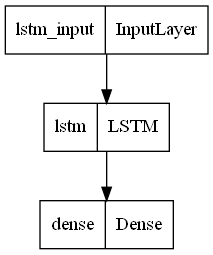

In [179]:
plot_model(model)

In [225]:
BATCH_SIZE = 16
# es = EarlyStopping(monitor='loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model_lstm.h5', monitor='loss', save_best_only=True)
mcp2 = ModelCheckpoint(filepath='best_model_gru.h5', monitor='loss', save_best_only=True)
history = model.fit(train_data, train_target, batch_size=BATCH_SIZE, callbacks=[mcp], epochs=50)
# model2.fit(train_data, train_target, batch_size=BATCH_SIZE, callbacks=[es,mcp2])

Epoch 1/50
118/118 [==============================] - 2s 5ms/step - loss: 0.0269 - mae: 0.0987
Epoch 2/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0168 - mae: 0.0607
Epoch 3/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0156 - mae: 0.0528
Epoch 4/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0151 - mae: 0.0496
Epoch 5/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0146 - mae: 0.0491
Epoch 6/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0142 - mae: 0.0476
Epoch 7/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0135 - mae: 0.0460
Epoch 8/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0126 - mae: 0.0450
Epoch 9/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0112 - mae: 0.0440
Epoch 10/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0094 - mae: 0.0416
Epoch 11/50
118/118 [============================

In [226]:
model.evaluate(test_data, test_target)

13/13 [==============================] - 0s 2ms/step - loss: 0.0199 - mae: 0.0470


[0.019903011620044708, 0.046975985169410706]

In [228]:
model.predict(test_data)[0]

13/13 [==============================] - 0s 3ms/step


array([ 0.03831294,  0.03894283, -0.00962339, -0.04034249,  0.01968701,
        0.04749823,  0.01088853], dtype=float32)

13/13 [==============================] - 0s 2ms/step


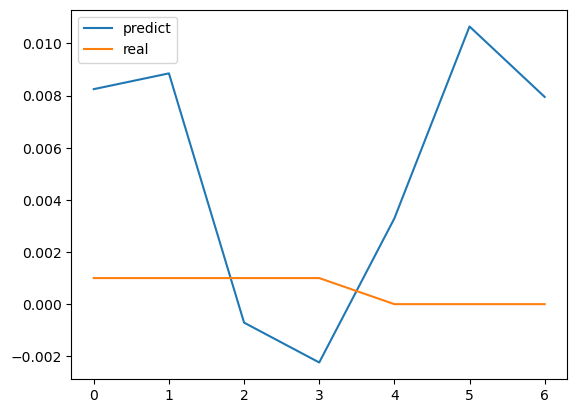

In [274]:
plt.plot(range(0,7), model.predict(test_data)[395])
plt.plot(range(0,7), test_target[395])
plt.legend(['predict','real'])
plt.show()

In [375]:
print(train_data.shape, test_data.shape)

(1873, 30, 5) (397, 30, 5)


In [377]:
print(len(input_data2)-TRAIN_SPLIT+len(input_data1))

1134


In [417]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((train_data, train_target))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(len(input_data2)-TRAIN_SPLIT).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((test_data, test_target))
val_data_multi = val_data_multi.batch(len(input_data2)-TRAIN_SPLIT).repeat()

model = Sequential()
model.add(LSTM(16,activation = 'relu',input_shape = (30,5)))
model.add(Dense(7)) # <- 예측 갯수에 따라서 dense 값 수정 할 것(현재 7일 예측)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='mse')

In [418]:
for x, y in val_data_multi.take(1):
    print(model.predict(x).shape)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

13/13 [==============================] - 0s 2ms/step
(397, 7)


In [435]:
##########모델생성############### 2
history = model.fit(train_data_multi, epochs = 100,
                                          batch_size = BATCH_SIZE,
                                          steps_per_epoch = len(train_data)//BATCH_SIZE, 
                                          validation_data = val_data_multi, validation_steps = len(test_data)// BATCH_SIZE, callbacks = [es,mc])

Epoch 1/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0067
Epoch 2/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 3/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0073
Epoch 4/100
117/117 [==============================] - 1s 10ms/step - loss: 9.7348e-04 - val_loss: 0.0063
Epoch 5/100
117/117 [==============================] - 1s 11ms/step - loss: 9.7313e-04 - val_loss: 0.0057
Epoch 6/100
117/117 [==============================] - 1s 11ms/step - loss: 9.4042e-04 - val_loss: 0.0054
Epoch 7/100
117/117 [==============================] - 1s 11ms/step - loss: 9.2574e-04 - val_loss: 0.0056
Epoch 8/100
117/117 [==============================] - 1s 11ms/step - loss: 9.3216e-04 - val_loss: 0.0063
Epoch 9/100
117/117 [==============================] - 1s 11ms/step - loss: 8.9872e-04 - val_loss: 0.0058
Epoch 10/100
117/117 [==============================] - 1s

In [433]:
##########모델생성###############
history = model.fit(train_data_multi, epochs = 100,
                                          batch_size = BATCH_SIZE,
                                          steps_per_epoch = len(input_data2)/BATCH_SIZE, 
                                          validation_data = val_data_multi, validation_steps = 14, callbacks = [es,mc])

Epoch 1/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 2/100
108/108 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 3/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 4/100
108/108 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 5/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 6/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 7/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 8/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 9/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 10/100
108/108 [==============================] - 1s 10ms/step - loss: 0.0018 

In [460]:
model.save("best_model2.h5")

13/13 [==============================] - 0s 2ms/step


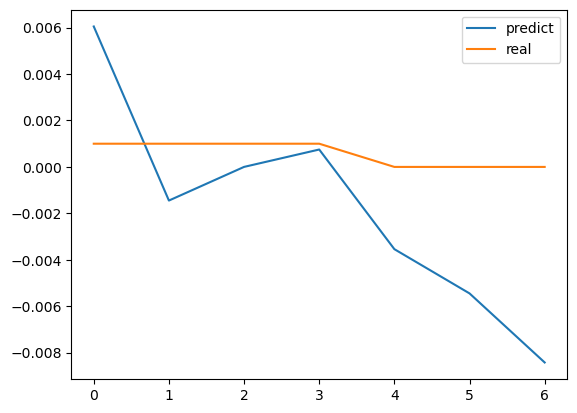

In [461]:
plt.plot(range(0,7), model.predict(test_data)[395])
plt.plot(range(0,7), test_target[395])
plt.legend(['predict','real'])
plt.show()

## 적조 예측

In [519]:
for x, y in train_data_multi.take(1):
    print(model.predict(x).shape)

14/14 [==============================] - 0s 2ms/step
(434, 7)


In [520]:
# y값 -> 실제 값 DataFrame에 저장

y_np_array = np.array(y)
real_value = pd.DataFrame(y_np_array)
# multi_step_model.predict 값 ->/ 예측 값 DataFrame에 저장
predict_value = pd.DataFrame(model.predict(x))

14/14 [==============================] - 0s 2ms/step


In [521]:
result = pd.concat([real_value,predict_value], axis=1)
result.columns = ['real_1','real_2','real_3','real_4','real_5', 'real_6', 'real_7','predict_1','predict_2','predict_3', 'predict_4', 'predict_5', 'predict_6', 'predict_7']

In [522]:
result

,real_1,real_2,real_3,real_4,real_5,real_6,real_7,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7
0,0.02667,0.01333,0.00889,0.00444,0.00296,0.00148,0.00099,0.038559,0.028147,0.004624,0.012897,0.002012,-0.014476,-0.002002
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.018362,0.012252,0.005184,0.008589,0.006190,0.000486,0.002628
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000938,-0.000125,0.001224,0.000153,-0.000650,-0.000430,-0.005090
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.000967,0.004808,-0.000295,-0.002805,-0.007410,-0.007836,0.001086
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.009430,0.000065,0.001481,-0.001947,-0.002179,0.002995,0.000087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.001510,-0.002003,0.004435,0.000873,-0.003100,0.000308,-0.004019
430,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.000331,0.001436,-0.003051,-0.001081,-0.002089,-0.003069,0.001416
431,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.010682,0.001831,-0.002399,0.004014,0.005740,0.002698,0.000226
432,0.12000,0.08000,0.04000,0.02667,0.01333,0.00889,0.00444,0.125085,0.052177,0.024723,0.018052,0.010782,-0.001280,-0.031852


In [523]:
for col in result.columns:    
    for i in range(0,len(result[col])):
        if int(result[col][i]) < 0:
            result[col][i] = 0
        if int(result[col][i]) > 1:
            result[col][i] = 1

### 적조발생 수치 계산

In [524]:
red_tied_rate = 0.1  #적조 발생 밀도 기준치
TP = result.real_1[(result['real_1'] >= red_tied_rate) & (result['predict_1'] >= red_tied_rate)].count()
TN = result.real_1[(result['real_1'] < red_tied_rate) & (result['predict_1'] < red_tied_rate)].count()
FN = result.real_1[(result['real_1'] >= red_tied_rate) & (result['predict_1'] < red_tied_rate)].count()
FP = result.real_1[(result['real_1'] < red_tied_rate) & (result['predict_1'] >= red_tied_rate)].count()
Pr = result.real_1[(result['real_1'] >= red_tied_rate)].count()
Nr = result.real_1[(result['real_1'] < red_tied_rate)].count()
Pp = result.real_1[(result['predict_1'] >= red_tied_rate)].count()
Np = result.real_1[(result['real_1'] < red_tied_rate)].count()
All = Pr + Nr

In [525]:
# TP2 = result.real[(result['real_3'] >= red_tied_rate) & (result['predict_3'] >= red_tied_rate)].count()
# TN2 = result.real[(result['real_3'] < red_tied_rate) & (result['predict_3'] < red_tied_rate)].count()
# FN2 = result.real[(result['real_3'] >= red_tied_rate) & (result['predict_3'] < red_tied_rate)].count()
# FP2 = result.real[(result['real_3'] < red_tied_rate) & (result['predict_3'] >= red_tied_rate)].count()
# Pr2 = result.real[(result['real_3'] >= red_tied_rate)].count()
# Nr2 = result.real[(result['real_3'] < red_tied_rate)].count()
# Pp2 = result.real[(result['predict_3'] >= red_tied_rate)].count()
# Np2 = result.real[(result['real_3'] < red_tied_rate)].count()
# All2 = Pr2 + Nr2

### 1일차 적조 예측

In [526]:
print("TP = {}".format(TP))
print("TN = {}".format(TN))
print("FN = {}".format(FN))
print("FP = {}".format(FP))
print("Pr = {}".format(Pr))
print("Nr = {}".format(Nr))
print("Pp = {}".format(Pp))
print("Np = {}".format(Np))
print("All = {}".format(All))

TP = 14
TN = 419
FN = 1
FP = 0
Pr = 15
Nr = 419
Pp = 14
Np = 419
All = 434


In [527]:
Precision = TP /(TP+FP)
Recall = TP /(TP+FN)
F1_Score = (2*Precision*Recall) / (Precision + Recall)
print("Precision = {}".format(Precision))
print("Recall = {}".format(Recall))
print("F1_Score = {}".format(F1_Score))

Precision = 1.0
Recall = 0.9333333333333333
F1_Score = 0.9655172413793104


In [486]:
print("Accuracy = {}".format((TP+TN)/ All))
print("Error Rate = {}".format((FP+FN)/ All))
print("Sensitivity = {}".format(TP /Pr))
print("Specificity = {}".format(TN /Nr))
print("Precision = {}".format(Precision))
print("Recall = {}".format(Recall))
print("F1_Score = {}".format(F1_Score))

Accuracy = 0.9748110831234257
Error Rate = 0.02518891687657431
Sensitivity = 0.5
Specificity = 0.9772151898734177
Precision = 0.1
Recall = 0.5
F1_Score = 0.16666666666666669


<AxesSubplot:>

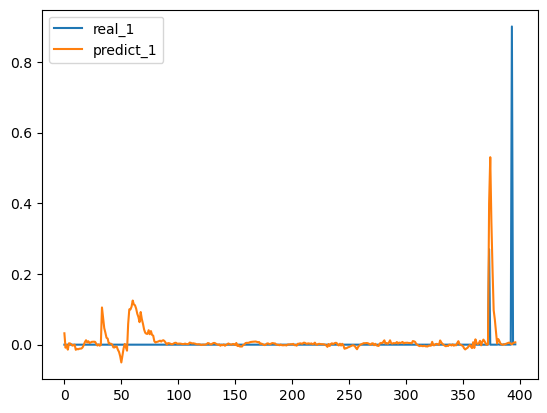

In [487]:
result[['real_1','predict_1']].plot()

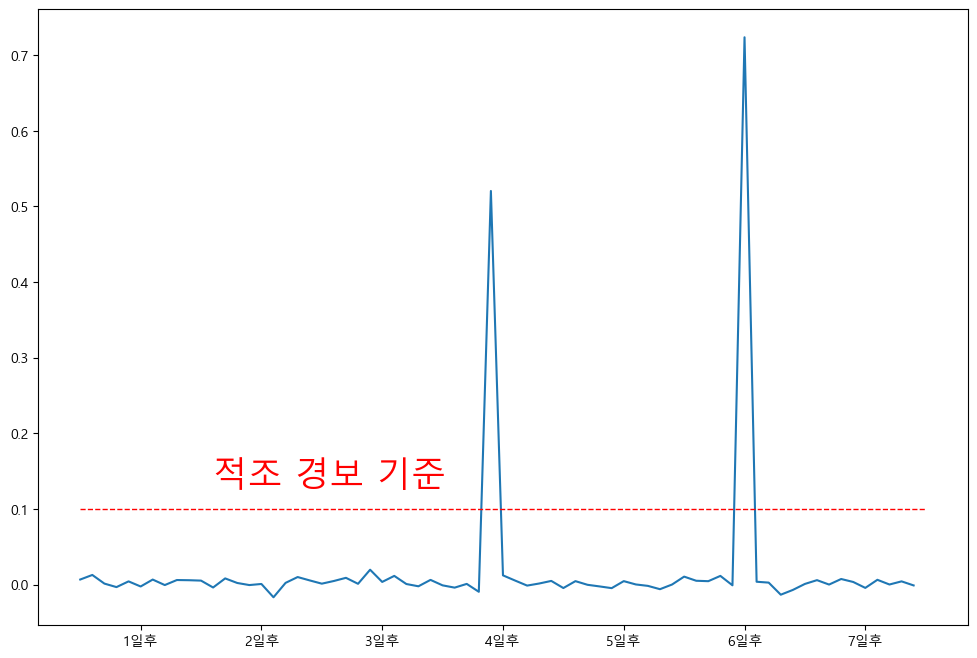

In [552]:
import platform

if	platform.system()	==	'Windows':
    plt.rc('font',	family='Malgun Gothic')
else:
    plt.rc('font',	family='AppleGothic')


x_range = range(len(result['real_1'][305:375]))
plt.rcParams['figure.figsize'] = (12,8)

plt.plot(x_range, result[f'predict_{1}'][305:375])
plt.hlines(0.1, 0, 70, color='red', linestyle='--', linewidth = 1)
plt.text(11,0.13, "적조 경보 기준", color='red', fontsize=25)
plt.xticks([5,15,25,35,45,55,65], ["1일후","2일후","3일후","4일후","5일후","6일후","7일후"])
plt.show()